In [1]:
import os
import numpy as np

In [2]:
from pyiron_workflow import Workflow, function_node

In [3]:
def generate_input(x, y, path, input_file="input.gnu"):
    data_file = os.path.join(path, 'xy.dat')
    np.savetxt(data_file, np.stack((x, y), axis=-1))
    gnuplot_script = "f(x) = a*x+b\nfit f(x) \"xy.dat\" using 1:2 via a,b"
    gnuplot_file = os.path.join(path, input_file)
    with open(gnuplot_file, "w") as f:
        f.write(gnuplot_script)
    return input_file

In [4]:
executable = "gnuplot \"input.gnu\""

In [5]:
def _get_gnuplot_parameter_line(content):
    for ii, line in enumerate(content):
        if line.startswith("Final set of parameters"):
            return ii + 2
    raise ValueError("line not found")
    
def get_gnuplot_parameters(content):
    parameter_line = _get_gnuplot_parameter_line(content)
    slope = float(content[parameter_line].split("=")[1].split()[0])
    intercept = float(content[parameter_line + 1].split("=")[1].split()[0])
    return slope, intercept

def parse_output(path, log_file="fit.log"):
    data_file = os.path.join(path, log_file)
    with open(data_file, "r") as f:
        content = f.readlines()
    return content

In [6]:
import subprocess

In [7]:
@Workflow.wrap.as_function_node
def create_working_directory(directory_name):
    os.makedirs("gnuplot", exist_ok=True)
    return directory_name

@Workflow.wrap.as_function_node
def run_executable(working_directory, input_file="input.gnu"):
    output = subprocess.run(f"gnuplot \"{input_file}\"", shell=True, cwd=working_directory)
    log_file = "fit.log"
    assert os.path.exists(os.path.join(working_directory, log_file))
    return log_file

In [8]:
x = np.linspace(0, 2 * np.pi)
y = np.sin(x)

In [9]:
wf = Workflow("gnuplot")
wf.directory = create_working_directory("gnuplot")
wf.gen_input = function_node(generate_input, x=x, y=y, path=wf.directory)
wf.executable = run_executable(working_directory=wf.directory, input_file=wf.gen_input)
wf.parse_output = function_node(parse_output, path=wf.directory, log_file=wf.executable)
wf.output = function_node(get_gnuplot_parameters, content=wf.parse_output)

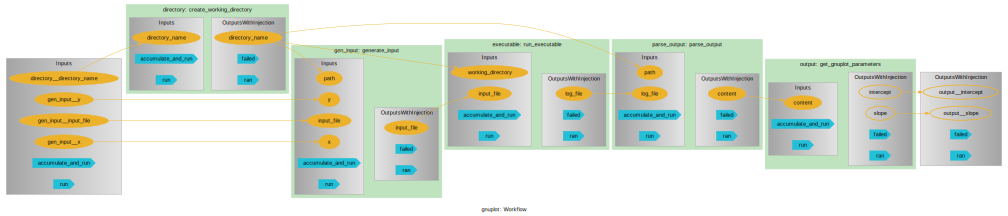

In [10]:
wf.draw(size=(14,14))

In [11]:
wf.run()

iter      chisq       delta/lim  lambda   a             b            
   0 1.1512125916e+03   0.00e+00  2.67e+00    1.000000e+00   1.000000e+00
   1 1.0697871469e+01  -1.07e+07  2.67e-01   -2.558865e-01   8.284167e-01
   2 1.0514493240e+01  -1.74e+03  2.67e-02   -2.857073e-01   8.974771e-01
   3 1.0514490936e+01  -2.19e-02  2.67e-03   -2.858103e-01   8.978994e-01
iter      chisq       delta/lim  lambda   a             b            

After 3 iterations the fit converged.
final sum of squares of residuals : 10.5145
rel. change during last iteration : -2.19137e-07

degrees of freedom    (FIT_NDF)                        : 48
rms of residuals      (FIT_STDFIT) = sqrt(WSSR/ndf)    : 0.46803
variance of residuals (reduced chisquare) = WSSR/ndf   : 0.219052

Final set of parameters            Asymptotic Standard Error
=======================            ==========================
a               = -0.28581         +/- 0.03577      (12.52%)
b               = 0.897899         +/- 0.1304       (14

{'output__slope': -0.28581, 'output__intercept': 0.897899}